In [1]:
import torch
import math
import sys; sys.path.append(".")
from mrd import core, data, models, callbacks
import lightning as pl
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
SEED = 0
DATA_ROOT = "./data_mnist"

WIDTH = 64           # <<<<< model size knob
DEPTH = 1              # number of hidden blocks after the first
USE_LAYERNORM = False
ACTIVATION = "gelu"    # "gelu" or "tanh"
D = 32

TRAIN_BS = 4096
DIAG_BS  = 4096

LR = 0.01
MOMENTUM = 1.0 # 0.9
WEIGHT_DECAY = 0 # 1e-4
NESTEROV = True
GRAD_CLIP = None # 1.0

MAX_STEPS = 400
VAL_EVERY_N_STEPS = 200
DIAG_EVERY_N_STEPS = 10
DIAG_K = 16

DEVICES = 1

PRECISION = "32-true"

In [9]:
g = torch.Generator(device="cpu"); g.manual_seed(SEED)
w = torch.randn(D, generator=g) / math.sqrt(D)
A = torch.randn(D, D, generator=g) / math.sqrt(D)

def f_star(X):  # X: (B,D)
    return data.target_sin_mix(X, w=w, A=A)

adm_cfg = data.AnalyticDMConfig(
    d=D,
    n_train=50_000,
    n_test=10_000,
    train_bs=TRAIN_BS,
    test_bs=TEST_BS,
    num_workers=1,
    noise_std=0.05,
    x_dist="normal",
    fixed_dataset=True,
    standardize_x=True,   # “whiten-ish” inputs
)

dm = data.AnalyticRegressionData(adm_cfg, target_fn=f_star)
dm.setup()

# sanity check shapes
xb, yb = next(iter(dm.train_dataloader()))

In [10]:
model = models.MLP(width=WIDTH, depth=DEPTH, in_dim=D, out_dim=1)

module = models.MRDTaskModule(
   model=model, task="regression",
    lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=NESTEROV
)

mrd_cb = callbacks.MRDDiagnosticsCallback(every_n_steps=DIAG_EVERY_N_STEPS, diag_bs=DIAG_BS, K=DIAG_K)

from lightning.pytorch.callbacks import TQDMProgressBar

class NotebookTQDM(TQDMProgressBar):
    def init_train_tqdm(self):
        bar = super().init_train_tqdm()
        bar.disable = False
        return bar

trainer = pl.Trainer(
    devices=DEVICES,
    precision=PRECISION,
    limit_val_batches=0,
    max_steps=MAX_STEPS,
    gradient_clip_val=GRAD_CLIP,
    log_every_n_steps=20,
    val_check_interval=None,
    enable_checkpointing=False,
    enable_model_summary=True,
    enable_progress_bar=True,
    callbacks=[NotebookTQDM(refresh_rate=20), mrd_cb],
    logger=False,   # keep notebook simple; metrics stored in mrd_cb.rows
)

trainer.fit(module, datamodule=dm)
trainer.test(module, datamodule=dm)

df = mrd_cb.dataframe()
df.tail()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model │ MLP  │  2.3 K │ train │     0 │
└───┴───────┴──────┴────────┴───────┴───────┘

Trainable params: 2.3 K                                                                      
Non-trainable params: 0                                                                      
Total params: 2.3 K                                                                          
Total estimated model params size (MB): 0                                                    
Modules in train mode: 7                                                                     
Modules in eval mode: 0                                                                      
Total FLOPs: 0

/home/ubuntu/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=29` in the `DataLoader` to improve performance.


Epoch 33: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, train/loss=0.0168]  

`Trainer.fit` stopped: `max_steps=400` reached.


Epoch 33: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, train/loss=0.0168]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=29` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 250.97it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/loss         │   0.017511410638689995    │
└───────────────────────────┴───────────────────────────┘

,step,loss,loss_name,P,batch,G_F,trG,R_F,m_F,mu,A,alpha,Phi_align_F_fd,Phi_damp_F_fd,Phi_trans_F_fd
35,360,0.040307,mse,2305,4096,3.213730,7.516373,0.128461,-3.334418,0.003261,3.209914,0.999783,0.288101,0.038834,0.007865
36,370,0.038295,mse,2305,4096,4.286137,9.626217,0.129580,-4.405919,0.004176,4.281444,0.999783,0.301188,0.036298,0.007984
37,380,0.038962,mse,2305,4096,3.874273,9.838623,0.126541,-3.990283,0.004268,3.868850,0.999783,0.301715,0.032802,0.007217
38,390,0.038012,mse,2305,4096,3.272651,6.981123,0.112887,-3.378568,0.003029,3.269419,0.999783,0.313755,0.032324,0.007043
39,400,0.034837,mse,2305,4096,3.759023,8.812098,0.112694,-3.862596,0.003823,3.754539,0.999783,0.282788,0.028571,0.006483


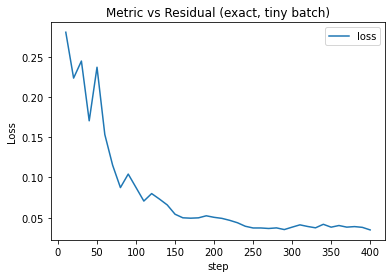

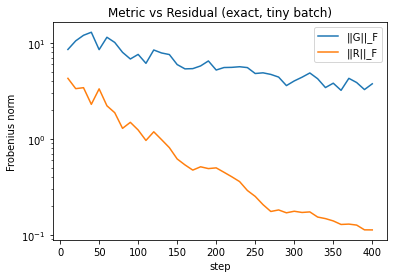

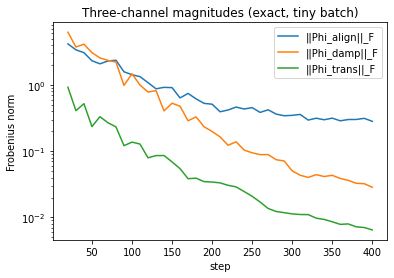

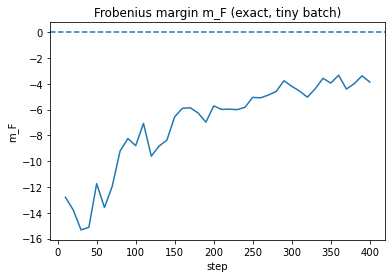

In [11]:
plt.figure()
plt.plot(df["step"], df.get("loss", pd.Series([float("nan")]*len(df))), label="loss")
plt.xlabel("step")
plt.ylabel("Loss")
plt.title("Metric vs Residual (exact, tiny batch)")
plt.legend()
plt.show()

plt.figure()
plt.plot(df["step"], df.get("G_F", pd.Series([float("nan")]*len(df))), label="||G||_F")
plt.plot(df["step"], df.get("R_F", pd.Series([float("nan")]*len(df))), label="||R||_F")
plt.xlabel("step")
plt.ylabel("Frobenius norm")
plt.yscale("log")
plt.title("Metric vs Residual (exact, tiny batch)")
plt.legend()
plt.show()

plt.figure()
plt.plot(df["step"], df.get("Phi_align_F_fd", pd.Series([float("nan")]*len(df))), label="||Phi_align||_F")
plt.plot(df["step"], df.get("Phi_damp_F_fd", pd.Series([float("nan")]*len(df))), label="||Phi_damp||_F")
plt.plot(df["step"], df.get("Phi_trans_F_fd", pd.Series([float("nan")]*len(df))), label="||Phi_trans||_F")
plt.xlabel("step")
plt.ylabel("Frobenius norm")
plt.yscale("log")
plt.title("Three-channel magnitudes (exact, tiny batch)")
plt.legend()
plt.show()

plt.figure()
plt.plot(df["step"], df.get("m_F", pd.Series([float("nan")]*len(df))))
plt.axhline(0.0, linestyle="--")
plt.xlabel("step")
plt.ylabel("m_F")
plt.title("Frobenius margin m_F (exact, tiny batch)")
plt.show()